In [24]:
import sqlite3
import pandas as pd

# List of database filenames
database_files = ["Treasury_Yields_data.db", "CoT_data.db", "FED_Data.db"]  # Add your database filenames

# Create an empty DataFrame to store the merged data
merged_data = pd.DataFrame()

# Iterate through each database
for db_file in database_files:
    # Create a connection to the database
    conn = sqlite3.connect(db_file)

    # Get a list of all tables in the database
    tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = conn.execute(tables_query).fetchall()

    # Filter tables that contain the phrase "weekly_percent_change"
    relevant_tables = [table[0] for table in tables if "weekly_percent_change" in table[0]]

    # Iterate through relevant tables
    for table_name in relevant_tables:
        # Read the table into a DataFrame
        query = f"SELECT * FROM '{table_name}';"
        df = pd.read_sql_query(query, conn, index_col='Date', parse_dates='Date')

        # Extract necessary columns (you may adjust this based on your data structure)
        #relevant_columns = ["column1", "column2", ...]  # Replace with your relevant column names
        #df = df[relevant_columns]
        # Rename columns by combining table name and existing column name
        new_columns = [f"{table_name}_{col}" for col in df.columns]
        df.columns = new_columns
        
        # Merge or join with the existing merged_data
        merged_data = pd.merge(merged_data, df, how='outer', left_index=True, right_index=True)

    # Close the database connection
    conn.close()

# If you want to fill NaN values with a specific value, you can use:
# merged_data = merged_data.fillna(your_value)

# Print or use the merged_data DataFrame
#print(merged_data)


In [25]:
merged_data = merged_data.drop('SOMA_weekly_percent_change_asOfDate', axis=1)

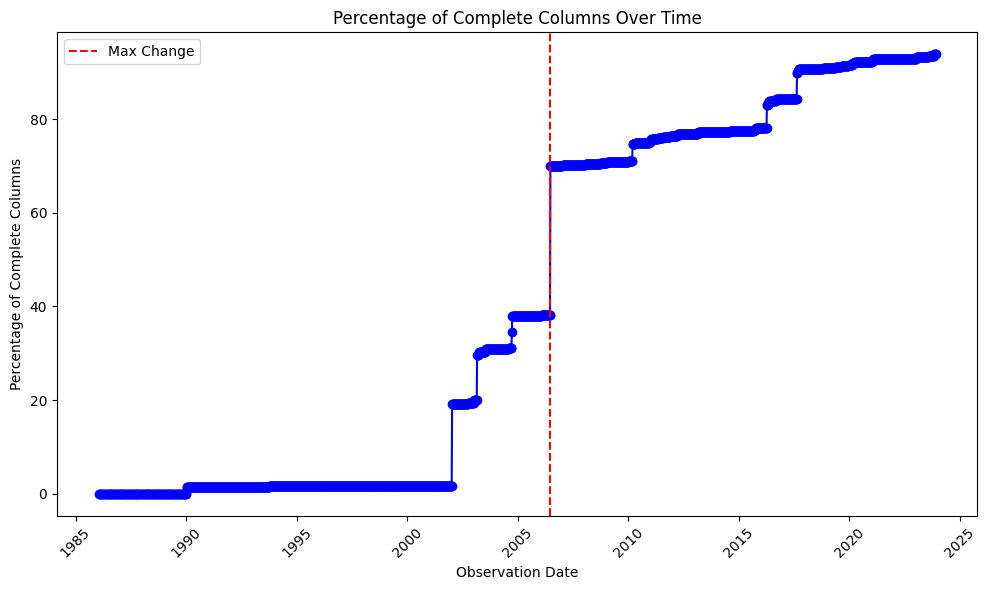

Date of the largest change: 2006-06-18 00:00:00


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create a copy of the merged data to avoid modifying the original
data_copy = merged_data.copy()

# Lists to store results
percentages = []
observation_dates = []

# Iterate backward through observations
for idx in reversed(range(len(data_copy.index))):
    current_observation = data_copy.iloc[idx:]

    # Check if there are any columns in the current observation
    if len(current_observation) > 0:
        # Count the number of numeric columns
        complete_columns_count = current_observation.dropna(axis='columns').shape[1]

        # Calculate the percentage of numeric columns
        percentage = complete_columns_count / current_observation.shape[1] * 100

        # Append results to lists
        percentages.append(percentage)
        observation_dates.append(current_observation.index[0])  # Use the index of the first observation

# Reverse the lists to maintain chronological order
percentages.reverse()
observation_dates.reverse()

# Calculate differences between consecutive percentages
percentage_diffs = np.diff(percentages)

# Find the index of the maximum difference
max_diff_index = np.argmax(np.abs(percentage_diffs))

# Get the dates corresponding to the largest changes
max_diff_start_date = observation_dates[max_diff_index]
max_diff_end_date = observation_dates[max_diff_index + 1]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(observation_dates, percentages, marker='o', linestyle='-', color='b')
plt.title('Percentage of Complete Columns Over Time')
plt.xlabel('Observation Date')
plt.ylabel('Percentage of Complete Columns')
plt.xticks(rotation=45)
plt.tight_layout()

# Highlight the largest change
plt.axvline(x=max_diff_start_date, color='r', linestyle='--', label='Max Change')

plt.legend()
plt.show()

# Print the dates corresponding to the largest changes
print("Date of the largest change:", max_diff_start_date)




In [27]:
# Reduce the merged_data DataFrame
reduced_data = merged_data.loc[max_diff_end_date:]

# Drop columns containing NA
reduced_data_cleaned = reduced_data.dropna(axis='columns')

# Display the reduced and cleaned DataFrame
print("Dimension of the Original DataFrame:", merged_data.shape)
print("Dimension of the Reduced and Cleaned DataFrame:", reduced_data_cleaned.shape)

Dimension of the Original DataFrame: (1865, 520)
Dimension of the Reduced and Cleaned DataFrame: (910, 364)


In [28]:
reduced_data_cleaned.to_csv('C:/Users/dstoc/Documents/Python Scripts/Fixed Income Dashboards/reduced_data_cleaned.csv', index=True)